## Title: Brain Tumor Classification
## Author: Sivaaneesh Barathala


In [1]:
##############################################################################################
# If using Linux/Mac, use the following commands to download dataset from Kaggle and extract it

# !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
# !unzip -q brain-tumor-mri-dataset.zip

# If using Windows, please use the following URL to download the dataset and manually extract it
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

# Make sure the script is in the same directory as the extracted folders (Training and Testing)
###############################################################################################

### Import required libraries

In [2]:
import os # library to handle OS relation operations such as listing directories, etc..
import json # to save and load JSON objects (used for metrics)
import random # used to shuffle images

import time # for time computations
import numpy as np # used to compute mean, etc..
from glob import glob # used to gather files from folders
import matplotlib.pyplot as plt  # matplotlib for data visualization

import torch  # PyTorch library
from torch import nn # nn package to handle deep learning components
from torch import optim # library for optimizers
import torchvision.utils as vutils # vision utils to save images (from GAN)
import torchvision.models as models # for pretrained models
import torchvision.datasets as datasets  # datasets from torchvision for loading data
from torch.utils.data import ConcatDataset # utility to concatenate datasets
import torchvision.transforms as transforms  # transforms from torchvision for data preprocessing
from torch.utils.data import Dataset, DataLoader  # DataLoader from PyTorch for batching and shuffling data
from torchvision.io import read_image, ImageReadMode # Used to read images into Python env

### Preprocess Data

In [3]:
# Few constants

TRAIN_DIR = "Training"  # Directory path for training data
TEST_DIR = "Testing"  # Directory path for testing data
FINAL_IMAGE_SIZE = 256 # Resize images to
BATCH_SIZE = 4 # Number of images in each batch

In [4]:
basic_transform = transforms.Compose([
    transforms.Resize([FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE]),
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load datasets with basic transformations (not using the following because it is crashing kernel sometimes)
# train_dataset = datasets.ImageFolder(root=train_dir, transform=basic_transform)
# test_dataset = datasets.ImageFolder(root=test_dir, transform=basic_transform)

#### Custom Dataset

In [5]:
class BrainTumorDataset(Dataset):
    "Custom pytorch compatible dataset for images"
    def __init__(self, split, transforms=None):
        super().__init__()
        self.split = split
        self.transforms = transforms

        # make sure the split is valid and use corresponding directory
        if self.split not in ("train", "test"):
            raise Exception("Not a valid split")
        elif self.split == "train":
            self.image_dir = "Training"
        else:
            self.image_dir = "Testing"

        # parse and gather image file paths according to each tumor type
        self.parsed_image_paths = self.parse_images(self.image_dir)
        # merge all the paths and shuffle them
        self.shuffled_image_paths = sum(self.parsed_image_paths.values(), [])
        random.shuffle(self.shuffled_image_paths)
        # map to convert categories into numbers
        self.tumor_label_map = {"notumor": 0, "glioma": 1, "meningioma": 2, "pituitary": 3}

    def parse_images(self, dir):
        "prepare a dictionary mapping tumors to their corresponding image filepaths"
        parsed_images = dict()
        for tumor_type in os.listdir(dir):
            # Ignore the hidden system folders that are sometimes created automatically
            if tumor_type.startswith("."):
                continue
            # for each tumor type, gather and store the corresponding image filepaths 
            parsed_images[tumor_type] = glob(os.path.join(dir, tumor_type, "*.jpg"))

        return parsed_images

    def plot_distribution(self, title=None):
        "plot the frequency distribution of the available samples"
        # A dictionary to store the frequency of each tumor type
        counts = {tumor: len(paths) for tumor, paths in self.parsed_image_paths.items()}
        # Create a bar plot
        plt.bar(counts.keys(), counts.values())
        for i, val in counts.items():
            plt.text(i, val + 10, val, ha="center")

        # Add title
        if title is None:
            title = f"[{self.split.upper()}] Frequency Distribution of Tumor types"
        plt.title(title)

        plt.show()

    def __len__(self):
        return len(sum(self.parsed_image_paths.values(), []))

    def show_samples(self, size=10, apply_transforms=False, title=None):
        "plot few sample images from each tumor type"
        plt.figure(figsize=(size, size))
        for i, tumor in enumerate(self.parsed_image_paths):
            for j in range(4):
                plt.subplot(4, 4, i * 4 + j + 1)
                # read the image in black/white mode
                img = read_image(self.parsed_image_paths[tumor][j], mode=ImageReadMode.GRAY)
                # apply transformations (if any)
                if apply_transforms and self.transforms:
                    pil_img = transforms.functional.to_pil_image(img)
                    img = self.transforms(pil_img)
                # plot the images
                plt.imshow(img.numpy().transpose(1, 2, 0), cmap="gray")
                plt.title(tumor)

        if title is None:
            title = f"[{self.split.upper()}] Sample scans of each tumor"

        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    def __getitem__(self, index):
        "return the image and label when indexed"
        # read the indexed path from shuffled image paths
        image_path = self.shuffled_image_paths[index]
        # read the image from imagepath in black/white mode
        image = read_image(image_path, mode=ImageReadMode.GRAY)
        # apply transformations (if any)
        if self.transforms:
            pil_image = transforms.functional.to_pil_image(image)
            image = self.transforms(pil_image)

        # extracting the tumor type from the filepath
        # example: Training/glioma/photo1234.jpg -> glioma
        tumor = os.path.split(os.path.split(image_path)[0])[-1]
        # map the tumor type to its number using the map
        tumor_label = self.tumor_label_map[tumor]
        # return image and the tumor-type-as-number
        return (image, tumor_label)


#### Training Dataset

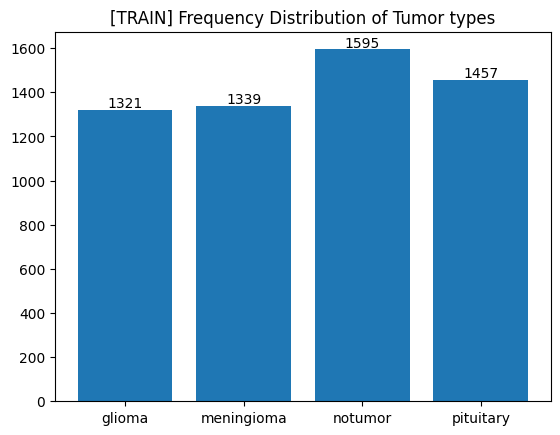

In [6]:
# Create train-dataset using the split: "train", and basic_transform
train_dataset = BrainTumorDataset("train", transforms=basic_transform)
# Plot the frequency distribution of the dataset
train_dataset.plot_distribution()

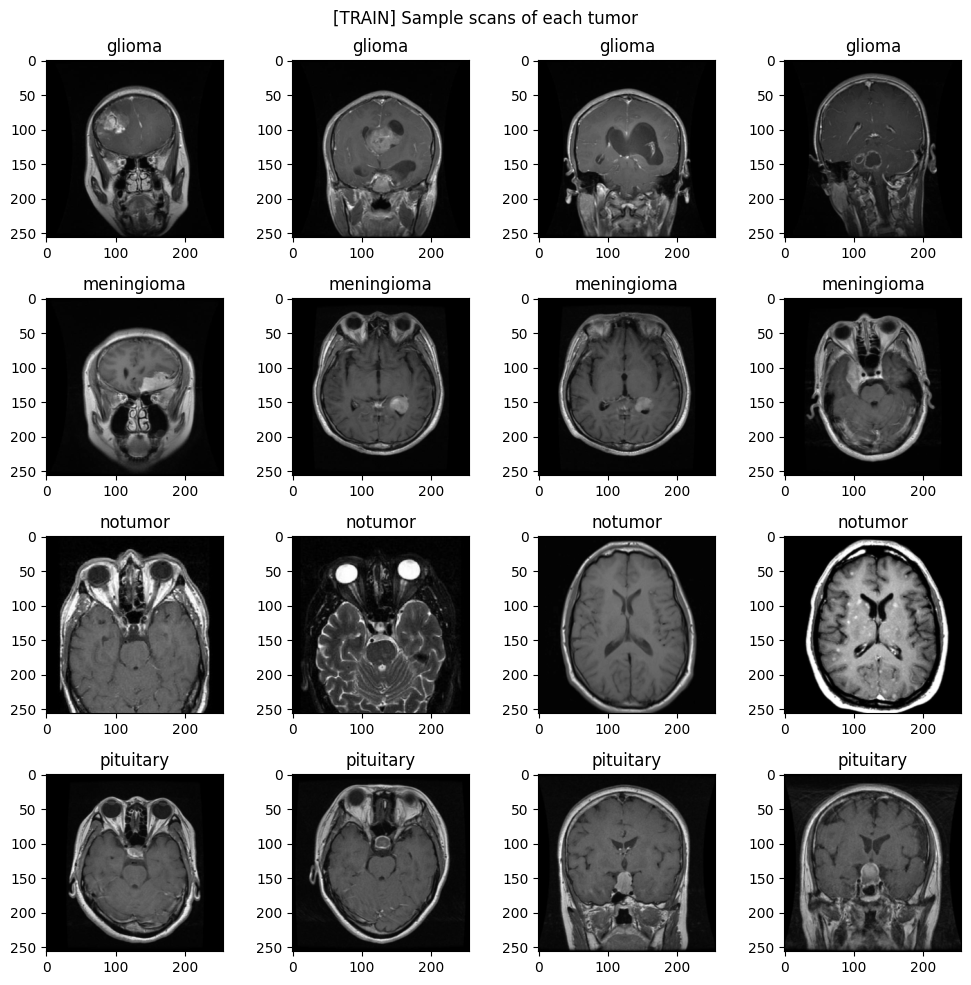

In [7]:
# show sample images after applying the transformations
train_dataset.show_samples(size=10, apply_transforms=True)

#### Testing Dataset

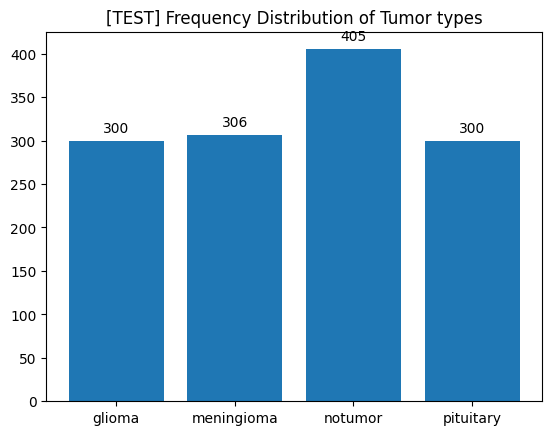

In [8]:
# Create test-dataset using the split: "test", and basic_transform
test_dataset = BrainTumorDataset("test", transforms=basic_transform)
# Plot the frequency distribution of the dataset
test_dataset.plot_distribution()

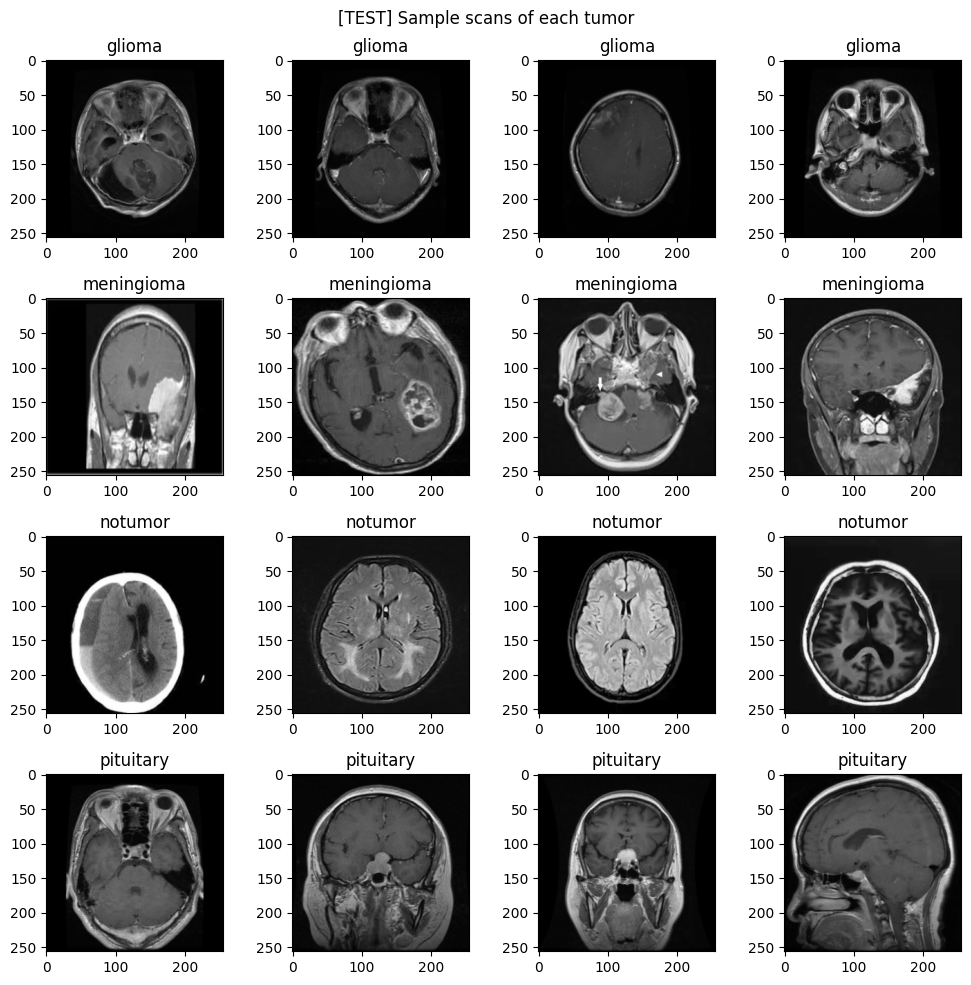

In [9]:
# show sample images after applying the transformations
test_dataset.show_samples(size=10, apply_transforms=True)

#### Dataloaders

In [10]:
# Create dataloaders with given batch-size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(f"Training samples: {len(train_dataset)}, Training batches: {len(train_loader)}")
print(f"Testing samples: {len(test_dataset)}, Testing batches: {len(test_loader)}")

Training samples: 5712, Training batches: 1428
Testing samples: 1311, Testing batches: 328


### Augmentation

In [12]:
aug_transforms = {
    'train': transforms.Compose([
        # Data augmentation and transformation for training set
        transforms.Grayscale(),
        transforms.Resize((FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE)),  # Resize images to 512x512
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.RandomResizedCrop(256, scale=(0.8, 1)),  # Randomly crop and resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ]),
    'test': transforms.Compose([
        # Transformation for testing set
        transforms.Grayscale(),
        transforms.Resize((FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE)),  # Resize images to 512x512
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ]),
}

# Load datasets with the defined transformations
train_dataset_aug = BrainTumorDataset(split="train", transforms=aug_transforms["train"])
test_dataset_aug = BrainTumorDataset(split="test", transforms=aug_transforms["test"])

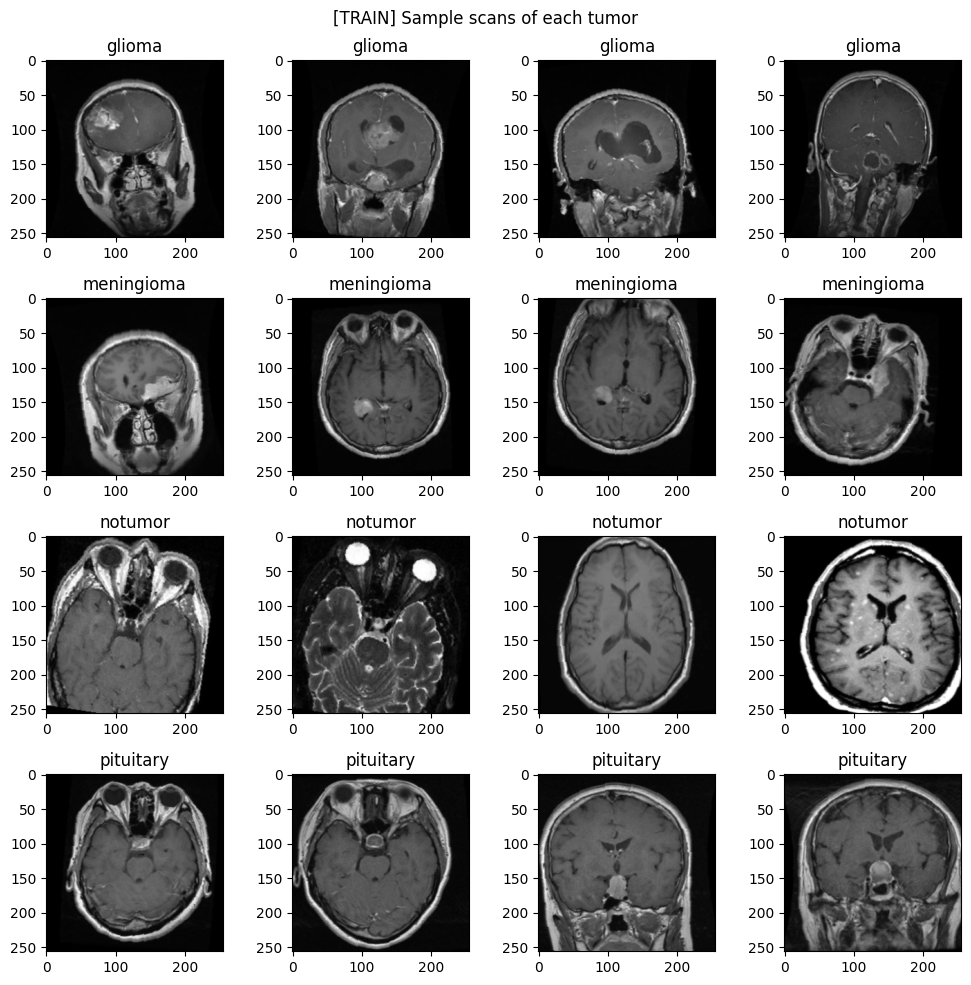

In [13]:
train_dataset_aug.show_samples(size=10, apply_transforms=True)

### Generative Adveserial Network - GAN

![image.png](https://www.researchgate.net/publication/338050169/figure/fig5/AS:849390331777024@1579521844061/The-general-architecture-of-GAN.ppm)

([Credits](https://www.researchgate.net/publication/338050169/figure/fig5/AS:849390331777024@1579521844061/The-general-architecture-of-GAN.ppm))

#### Model

In [14]:
USE_GAN = False

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1, bias=False),  # 256x256
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1, bias=False),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise use CPU
print(f"Using device: {device}")  # Print the device being used

Using device: cuda


#### Components

In [17]:
netG = Generator().to(device)  # Move the Generator model to the selected device
netD = Discriminator().to(device)  # Move the Discriminator model to the selected device

criterion = nn.BCELoss()  # Binary Cross-Entropy loss function
lr = 0.0001  # Learning rate for the optimizers

optimizerD = optim.Adam(netD.parameters(), lr=lr)  # Adam optimizer for the Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr)  # Adam optimizer for the Generator

#### Training - GAN

In [18]:
num_epochs = 100 # number of epochs
nz = 100 # noise

if USE_GAN:
    # Training loop
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            # Step 1: Update D network

            ## Train with real images
            netD.zero_grad()
            real_images = real_images.to(device)
            b_size = real_images.size(0)
            label = torch.full((b_size,), 1, dtype=torch.float, device=device)
            output = netD(real_images)
            errD_real = criterion(output, label)
            errD_real.backward()

            ## Train with fake images
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(0)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optimizerD.step()
            errD = errD_real + errD_fake

            # Step 2: Update G network
            netG.zero_grad()
            label.fill_(1)
            output = netD(fake_images)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            # Print training stats
            if i % 1000 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                    Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f}')

        # Save images every 10 epochs
        if epoch % 5 == 0:
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            vutils.save_image(fake, f'output/fake_images_epoch_{epoch}.png', normalize=True)

    # Save the trained models
    torch.save(netG.state_dict(), 'generator.pth')
    torch.save(netD.state_dict(), 'discriminator.pth')

![GAN GIF](gan.gif)

Final Output after 100 epochs:

![Final Output](gan-output/fake_images_epoch_95.png)


After running the GAN for 100 epochs, the generated images did not achieve a quality level sufficient for expanding the dataset. In the field of medical sciences, the risks associated with using GAN-generated images are particularly high due to the critical nature of accurate and reliable data. Given the current performance of the GAN and the potential risks, we have decided not to incorporate GAN-generated images into the dataset for the remainder of the project.

### Merging Datasets

In [19]:
# Concatenate regualr dataset and augmented dataset into a single dataset
train_dataset_reg_aug = ConcatDataset([train_dataset, train_dataset_aug])
test_dataset_reg_aug = ConcatDataset([test_dataset, test_dataset_aug])

# Create dataloaders with given batch size
train_loader_reg_aug = DataLoader(train_dataset_reg_aug, batch_size=BATCH_SIZE, shuffle=True)
test_loader_reg_aug = DataLoader(test_dataset_reg_aug, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
print(f"[REG+AUG] Training samples: {len(train_dataset_reg_aug)}, Training batches: {len(train_loader_reg_aug)}")
print(f"[REG+AUG] Testing samples: {len(test_dataset_reg_aug)}, Testing batches: {len(test_loader_reg_aug)}")

[REG+AUG] Training samples: 11424, Training batches: 2856
[REG+AUG] Testing samples: 2622, Testing batches: 656


### Custom Model - VGG16

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*NNifzsJ7tD2kAfBXt3AzEg.png" width="750" height="400">

([Credits](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*NNifzsJ7tD2kAfBXt3AzEg.png))

#### Model

In [21]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Input shape: 256 x 256 x 1 (Height x Width x Channels)

            # Convolutional Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 128 x 128 x 64

            # Convolutional Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 64 x 64 x 128

            # Convolutional Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 32 x 32 x 256

            # Convolutional Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: 16 x 16 x 512

            # # Convolutional Block 5
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # # Output shape: 8 x 8 x 512
        )

        self.classifier = nn.Sequential(
            # we end up with 16x16 images after conv block 4.
            nn.Linear(512 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
num_classes = 4  # 4 different types of tumors
vgg_model = VGG16(num_classes)
vgg_model = torch.jit.script(vgg_model)

vgg_model.save('vgg16_jit_scripted.pt')

#### Components

In [22]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.001

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=learning_rate)

vgg_model = vgg_model.to(device)

#### Training

In [23]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device, print_interval=500, name="Untitled"):
    "A function to train, validate, and save model"

    # Initialize lists to store metrics for logging and graph generation
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    iter_losses = []
    iter_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize metrics to 0
        running_loss = 0.0
        correct = 0
        total = 0

        epoch_start_time = time.time()

        for batch_idx, (images, labels) in enumerate(train_loader):
            batch_start_time = time.time()
            # Transfer the data onto the current device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate running loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Compute batch loss and accuracy
            batch_loss = loss.item()
            batch_accuracy = (predicted.eq(labels).sum().item() / labels.size(0)) * 100

            # Log iteration-wise metrics
            iter_losses.append(batch_loss)
            iter_accuracies.append(batch_accuracy)

            # Print batch metrics every print_interval batches
            if (batch_idx + 1) % print_interval == 0:
                avg_loss = running_loss / ((batch_idx + 1) * images.size(0))
                avg_accuracy = (correct / total) * 100
                elapsed = time.time() - batch_start_time
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_loader)}] | "
                      f"Avg Loss: {avg_loss:.4f} | Avg Accuracy: {avg_accuracy:.2f}% | "
                      f"Time: {elapsed:.2f}s")

        # Compute epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = (correct / total) * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        #####################################################################################################
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(test_loader.dataset)
        val_accuracy = (correct / total) * 100

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        epoch_elapsed = time.time() - epoch_start_time
        total_elapsed = time.time() - start_time
        est_time_remaining = total_elapsed / (epoch + 1) * (num_epochs - epoch - 1)

        print(f"Epoch [{epoch+1}/{num_epochs}] complete. Time taken: {epoch_elapsed:.2f}s. Estimated time remaining: {est_time_remaining:.2f}s.")

    #################################################################################################################
    # Save the model checkpoint
    torch.save(model.state_dict(), f"{name}.pth")

    # Save the metrics to a file
    metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "iter_losses": iter_losses,
        "iter_accuracies": iter_accuracies
    }
    with open(f"{name}_metrics.json", "w") as f:
        json.dump(metrics, f)


In [24]:
vgg_model_name = "VGG_16"
num_epochs = 50

vgg_model_path = f"{vgg_model_name}.pth"
vgg_metrics_path = f"{vgg_model_name}_metrics.json"

# Check if the model file exists
if not os.path.exists(vgg_model_path):
    print(f"Model file '{vgg_model_path}' not found. Training the model...")
    
    # Train the model
    train_model(
        model=vgg_model,
        train_loader=train_loader_reg_aug,
        test_loader=test_loader_reg_aug,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=num_epochs,
        device=device,
        name=vgg_model_name
    )
    
    print(f"Model trained and saved as '{vgg_model_path}'.")
else:
    print(f"Model file '{vgg_model_path}' already exists. Skipping training...")

Model file 'VGG_16.pth' already exists. Skipping training...


#### Load

In [25]:
# Load the metrics from the JSON file
if os.path.exists(vgg_metrics_path):
    with open(vgg_metrics_path, 'r') as f:
        vgg_metrics = json.load(f)
    print(f"Metrics loaded from '{vgg_metrics_path}'.")
else:
    vgg_metrics = None
    print(f"Missing metrics file '{vgg_metrics_path}'.")

Metrics loaded from 'VGG_16_metrics.json'.


#### Results

In [26]:
def plot_metrics(metrics, model_name):
    if not metrics:
        print("No metrics to plot.")
        return
    
    train_losses = metrics.get('train_losses', [])
    train_accuracies = metrics.get('train_accuracies', [])
    val_losses = metrics.get('val_losses', [])
    val_accuracies = metrics.get('val_accuracies', [])
    iter_losses = metrics.get('iter_losses', [])
    iter_accuracies = metrics.get('iter_accuracies', [])

    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    # First row: Train losses and Train accuracies
    axs[0, 0].plot(train_losses, label='Train Loss')
    axs[0, 0].set_title('Train Losses')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(train_accuracies, label='Train Accuracy')
    axs[0, 1].set_title('Train Accuracies')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Second row: Validation losses and Validation accuracies
    axs[1, 0].plot(val_losses, label='Validation Loss')
    axs[1, 0].set_title('Validation Losses')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    axs[1, 1].plot(val_accuracies, label='Validation Accuracy')
    axs[1, 1].set_title('Validation Accuracies')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    # Third row: Iteration-wise train losses and accuracies
    axs[2, 0].plot(iter_losses, label='Iteration Loss')
    axs[2, 0].set_title('Iteration-wise Train Losses')
    axs[2, 0].set_xlabel('Iteration')
    axs[2, 0].set_ylabel('Loss')
    axs[2, 0].legend()

    axs[2, 1].plot(iter_accuracies, label='Iteration Accuracy')
    axs[2, 1].set_title('Iteration-wise Train Accuracies')
    axs[2, 1].set_xlabel('Iteration')
    axs[2, 1].set_ylabel('Accuracy')
    axs[2, 1].legend()

    plt.suptitle(f"Overall Metrics - {model_name}")
    plt.tight_layout()
    plt.show()


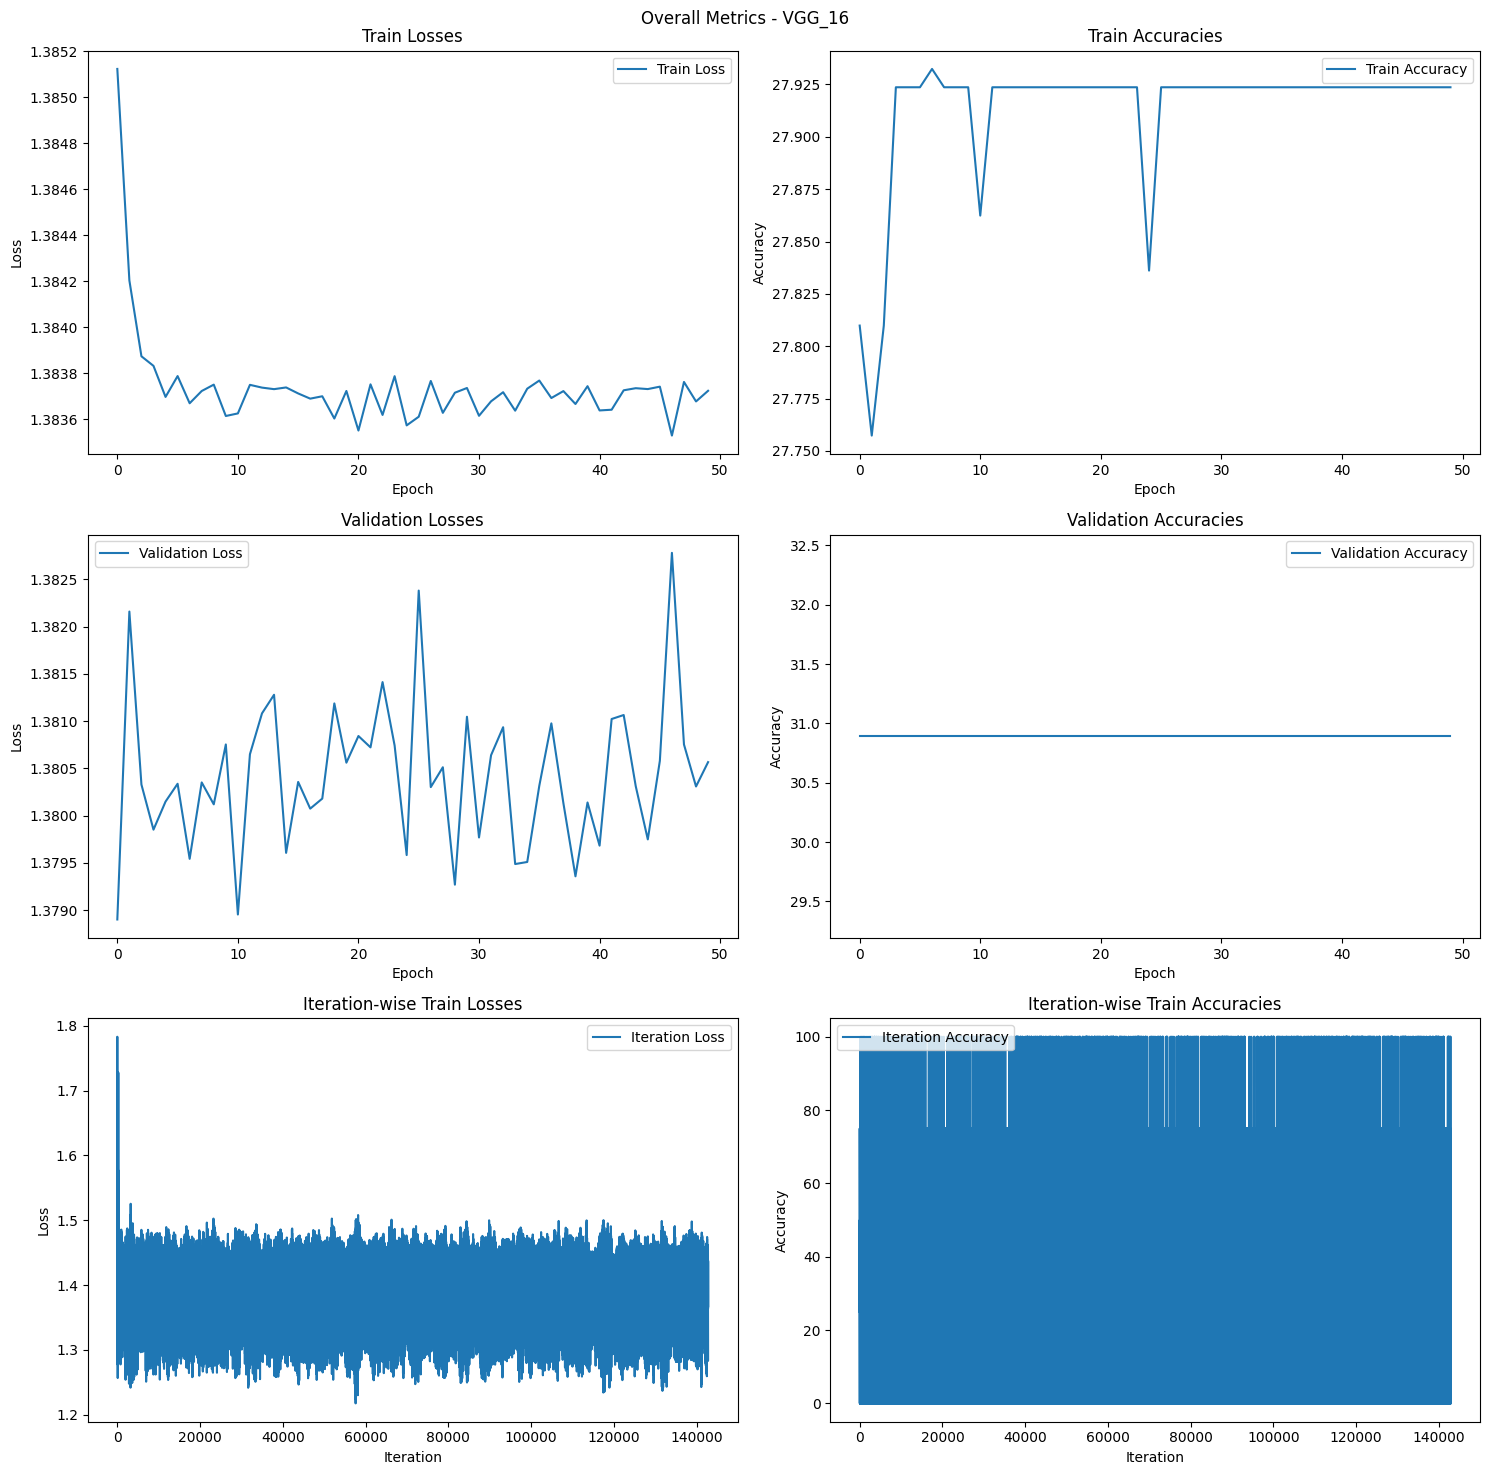

In [27]:
plot_metrics(vgg_metrics, model_name=vgg_model_name)

### Pretrained Model 1 - DenseNet

#### Model

In [28]:
# Load the pretrained DenseNet model
densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Modify the final layer to match the number of classes in the dataset
num_classes = 4
densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

# Move the model to the appropriate device
densenet = densenet.to(device)

#### Components

In [29]:
# Define optimizer and criterion
optimizer_densenet = optim.Adam(densenet.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#### Training

In [30]:
densenet_model_name = "DenseNet"
num_epochs = 50

densenet_model_path = f"{densenet_model_name}.pth"
densenet_metrics_path = f"{densenet_model_name}_metrics.json"

# Check if the model file exists
if not os.path.exists(densenet_model_path):
    print(f"Model file '{densenet_model_path}' not found. Training the model...")
    
    # Train the model
    train_model(
        model=densenet,
        train_loader=train_loader_reg_aug,
        test_loader=test_loader_reg_aug,
        optimizer=optimizer_densenet,
        criterion=criterion,
        num_epochs=num_epochs,
        device=device,
        name=densenet_model_name
    )
    
    print(f"Model trained and saved as '{densenet_model_path}'.")
else:
    print(f"Model file '{densenet_model_path}' already exists. Skipping training...")

Model file 'DenseNet.pth' already exists. Skipping training...


#### Load

In [31]:
# Load the metrics from the JSON file
if os.path.exists(densenet_metrics_path):
    with open(densenet_metrics_path, 'r') as f:
        densenet_metrics = json.load(f)
    print(f"Metrics loaded from '{densenet_metrics_path}'.")
else:
    densenet_metrics = None
    print(f"Missing metrics file '{densenet_metrics_path}'.")

Metrics loaded from 'DenseNet_metrics.json'.


#### Results

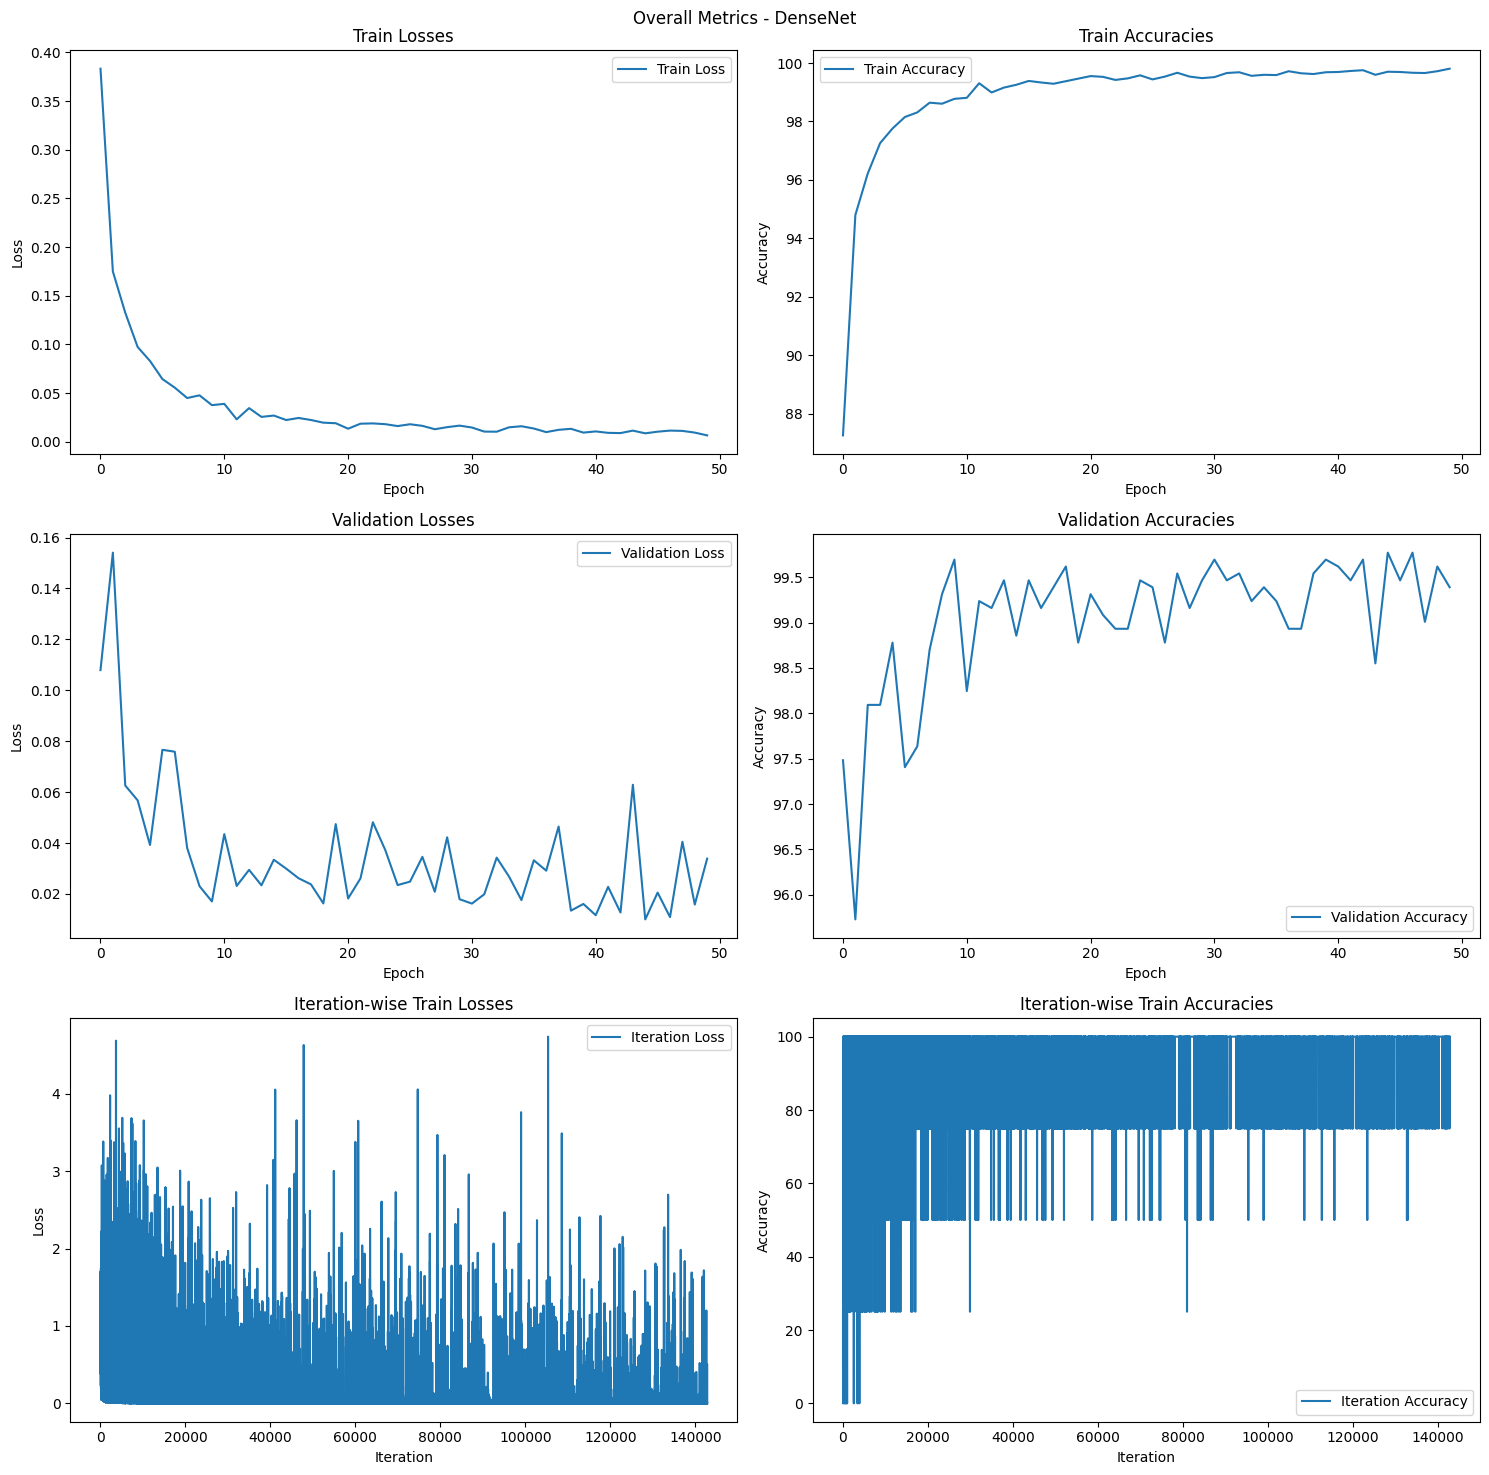

In [32]:
plot_metrics(densenet_metrics, model_name=densenet_model_name)

### Pretrained Model 2 - EfficientNet

#### Model

In [33]:

# Load the pretrained EfficientNet model
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Modify the first convolutional layer to accept 1 input channel
efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final layer to match the number of classes in the dataset
num_classes = 4  
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

# Move the model to the appropriate device
efficientnet = efficientnet.to(device)

#### Components

In [34]:
# Define optimizer and criterion
optimizer_efficientnet = torch.optim.Adam(efficientnet.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#### Training

In [35]:
efficientnet_model_name = "EfficientNet"
num_epochs = 50

efficientnet_model_path = f"{efficientnet_model_name}.pth"
efficientnet_metrics_path = f"{efficientnet_model_name}_metrics.json"

# Check if the model file exists
if not os.path.exists(efficientnet_model_path):
    print(f"Model file '{efficientnet_model_path}' not found. Training the model...")
    
    # Train the model
    train_model(
        model=efficientnet,
        train_loader=train_loader_reg_aug,
        test_loader=test_loader_reg_aug,
        optimizer=optimizer_efficientnet,
        criterion=criterion,
        num_epochs=num_epochs,
        device=device,
        name=efficientnet_model_name
    )
    
    print(f"Model trained and saved as '{efficientnet_model_path}'.")
else:
    print(f"Model file '{efficientnet_model_path}' already exists. Skipping training...")

Model file 'EfficientNet.pth' already exists. Skipping training...


#### Load

In [36]:
# Load the metrics from the JSON file
if os.path.exists(efficientnet_metrics_path):
    with open(efficientnet_metrics_path, 'r') as f:
        efficientnet_metrics = json.load(f)
    print(f"Metrics loaded from '{efficientnet_metrics_path}'.")
else:
    efficientnet_metrics = None
    print(f"Missing metrics file '{efficientnet_metrics_path}'.")

Metrics loaded from 'EfficientNet_metrics.json'.


#### Results

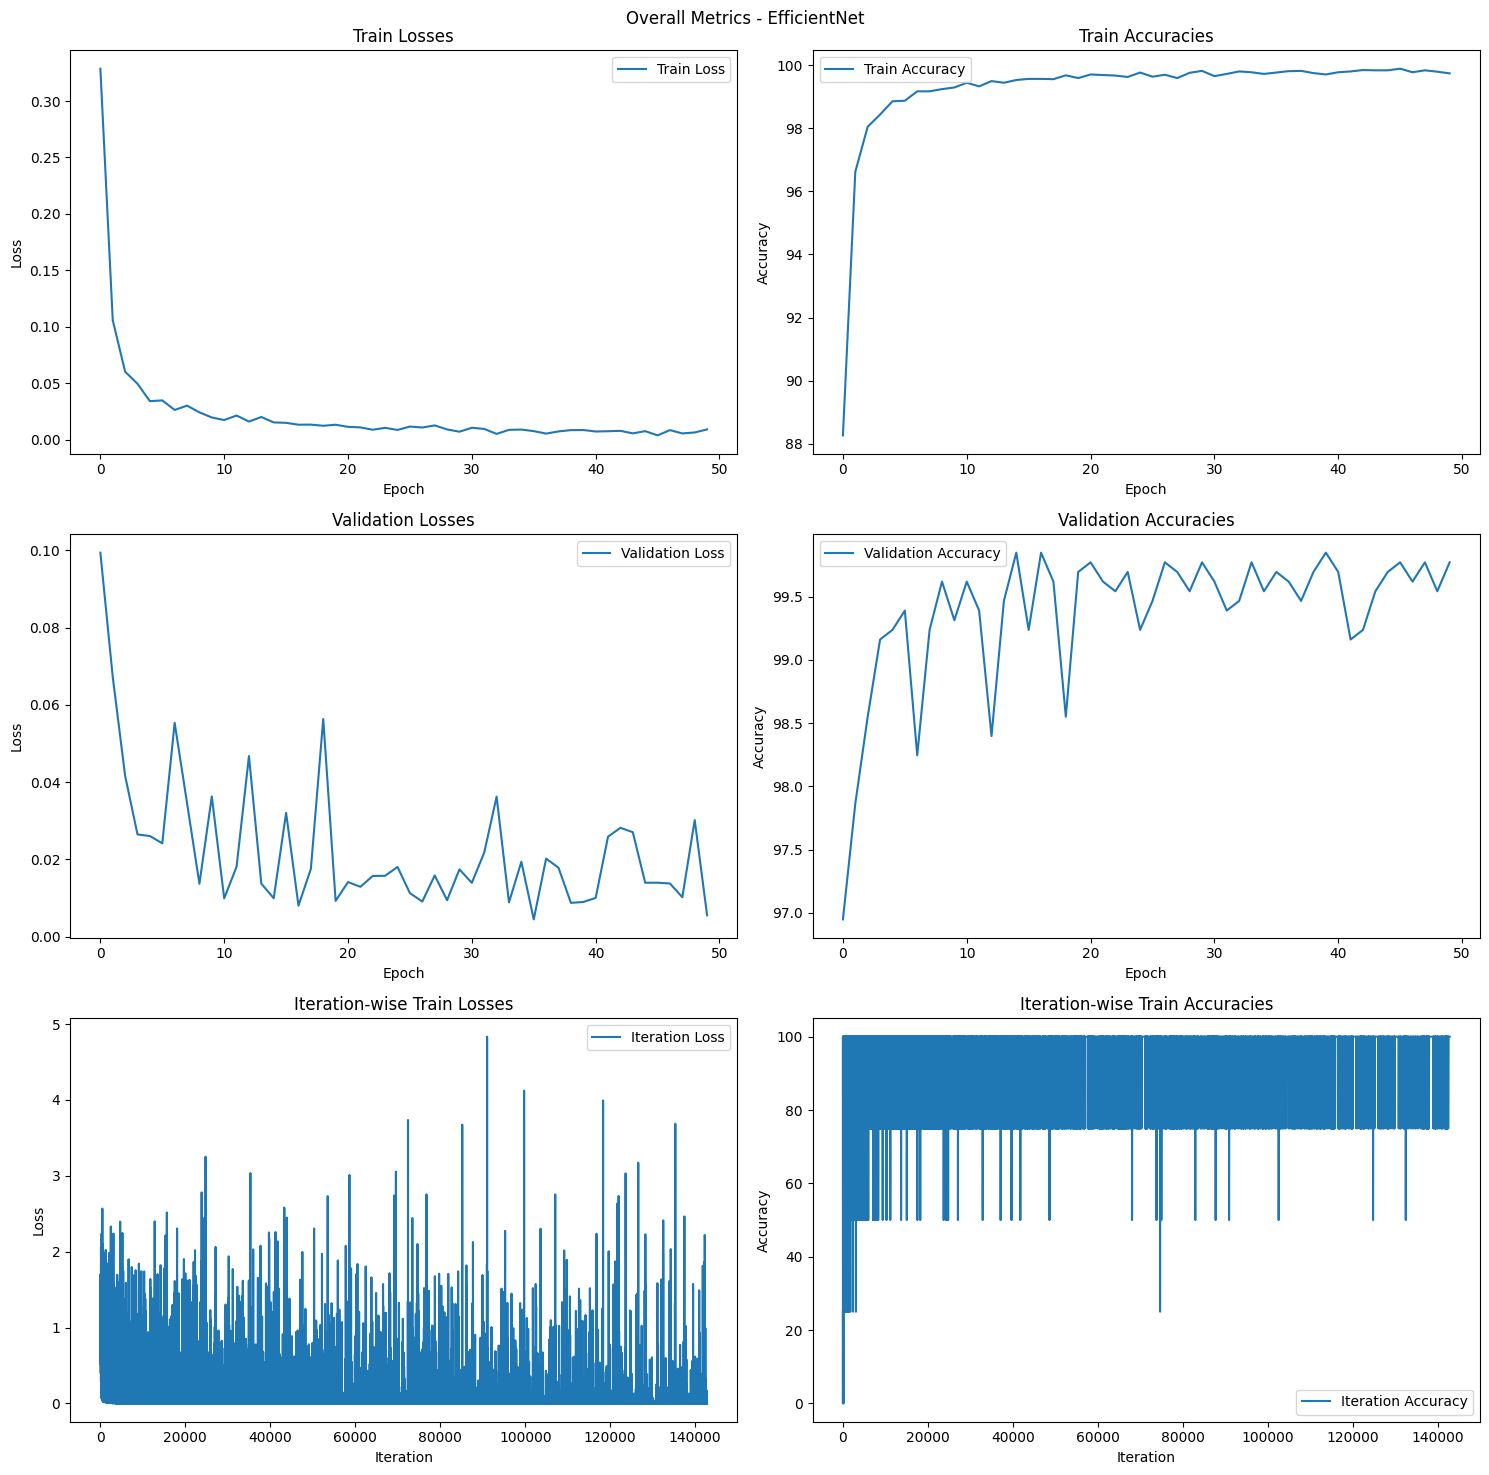

In [37]:
plot_metrics(efficientnet_metrics, model_name=efficientnet_model_name)

### Comparison

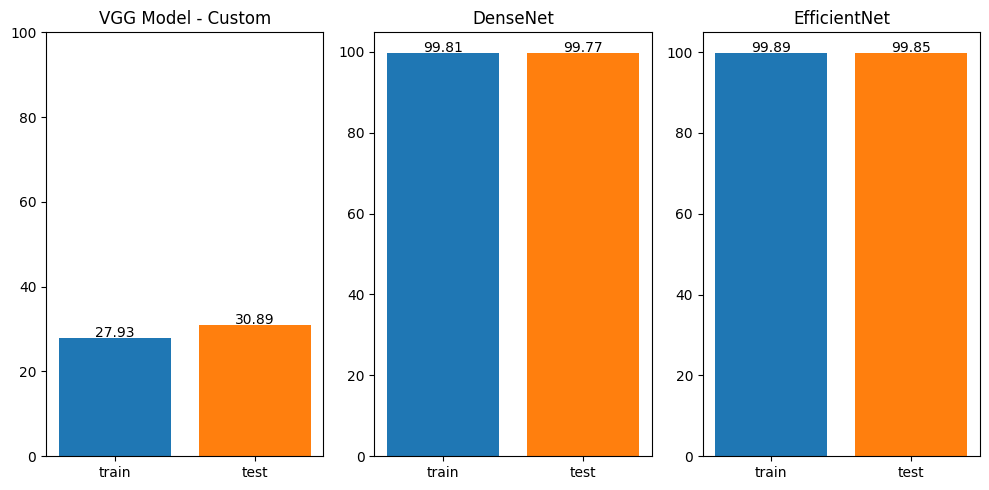

In [66]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
vgg_acc_best = {"train": max(vgg_metrics["train_accuracies"]), "test": max(vgg_metrics["val_accuracies"])}
plt.bar(list(vgg_acc_best.keys()), list(vgg_acc_best.values()), color=["C0", "C1"])
for key, val in vgg_acc_best.items():
    plt.text(key, val+0.2, round(val, 2), ha="center")
plt.title("VGG Model - Custom")
plt.ylim([0, 100])

plt.subplot(1, 3, 2)
densenet_acc_best = {"train": max(densenet_metrics["train_accuracies"]), "test": max(densenet_metrics["val_accuracies"])}
plt.bar(list(densenet_acc_best.keys()), list(densenet_acc_best.values()), color=["C0", "C1"])
for key, val in densenet_acc_best.items():
    plt.text(key, val+0.2, round(val, 2), ha="center")
plt.title("DenseNet")
# plt.ylim([0, 100])

plt.subplot(1, 3, 3)
efficientnet_acc_best = {"train": max(efficientnet_metrics["train_accuracies"]), "test": max(efficientnet_metrics["val_accuracies"])}
plt.bar(list(efficientnet_acc_best.keys()), list(efficientnet_acc_best.values()), color=["C0", "C1"])
for key, val in efficientnet_acc_best.items():
    plt.text(key, val+0.2, round(val, 2), ha="center")
plt.title("EfficientNet")
# plt.ylim([0, 100])

plt.tight_layout()